In [ ]:
import simpy
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ETAPA 1: EXTRAÇÃO DE DADOS

def get_process_times_from_csv(arquivo):
    """Lê um arquivo CSV Yamazumi, aplica um fator de calibração e extrai os tempos."""
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str): return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3: h, m, s = map(int, parts); return h * 3600 + m * 60 + s
            if len(parts) == 2: m, s = map(int, parts); return m * 60 + s
        except (ValueError, TypeError): return 0
        return 0

    try:
        if not os.path.exists(arquivo): return None
        df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')
        class_col = next((col for col in df.columns if 'Classifica' in col), None)
        if not class_col: return None
        total_row = df[df[class_col] == 'Total'].copy()
        if total_row.empty: return None

        start_col = df.columns.get_loc(class_col) + 1
        end_col = len(df.columns)
        try: end_col = df.columns.get_loc('Coluna1')
        except KeyError: pass
            
        colunas_postos = df.columns[start_col:end_col]
        tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
        tempos_formatados = tempos_totais.melt(var_name='Posto', value_name='Tempo_str')
        
        # Aplica o fator de calibração aqui
        tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)
        
        return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Posto).to_dict()

    except Exception: return None

# --- PARÂMETROS GLOBAIS ---
# FATOR_DE_CALIBRACAO = 0.15 
NUM_OPERADORES_PERNA1 = 14  
NUM_OPERADORES_PERNA2 = 11  
HORAS_SIMULACAO = 8
META_PRODUCAO = 76
HORAS_META = 7.7 
TAKT_TIME_SEGUNDOS = 5.5 * 60



MODELOS_CSV ={
    "Accelo": {"baumster": ["C951102", "C951104", "C951111"], "perna": 1, "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumster":["C951500", "C951501", "C951511", "C951514", "C951530", "C951544"],"perna": 1, "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumster": ["C968403", "C968114"], "perna": 1, "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": 2, "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumster":["C964016", "C964216", "C964231", "C964416"], "perna": 2, "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":2, "tempos": "Yamazumi - Actros.csv"}
}

# MODELOS_CSV = {
#   "Atego": "Yamazumi - Atego.csv", "ATP": "Yamazumi - ATP.csv",
#     "Actros": "Yamazumi - Actros.csv", "Arocs": "Yamazumi - Arocs.csv",
# }

print("--- Carregando e Calibrando Dados de Processo ---")
PROCESSOS_FABRICA = {modelo: get_process_times_from_csv(arquivo) for modelo, arquivo in MODELOS_CSV["tempos"]}
PROCESSOS_FABRICA = {k: v for k, v in PROCESSOS_FABRICA.items() if v}
print(PROCESSOS_FABRICA)
print(f"Dados para {len(PROCESSOS_FABRICA.keys())} modelos carregados com sucesso.")



--- Carregando e Calibrando Dados de Processo ---
{'Accelo': {'Arrefec.': 316, 'Diesel': 253, 'Reaperto': 235, 'Estepe': 290, 'Pneu LD': 250, 'Pneu LE': 250, 'Aperto LD': 304, 'Aperto LE': 304, 'Grade': 270, 'MecÃ¢nica 1': 194, 'MecÃ¢nica 2': 194, 'ElÃ©trica 1 ': 357, 'ElÃ©trica 2': 357, 'Controle ': 265, 'Motorista': 266, 'Quis': 270}, 'Atego': {'Arrefec.': 314, 'Diesel': 314, 'Reaperto': 294, 'Estepe': 267, 'Pneu LD': 308, 'Pneu LE': 308, 'Aperto LD': 315, 'Aperto LE': 315, 'Grade': 234, 'MecÃ¢nica 1': 194, 'MecÃ¢nica 2': 194, 'ElÃ©trica 1 ': 360, 'ElÃ©trica 2': 360, 'Controle ': 275, 'Motorista': 266, 'Quis': 270}, 'ATP': {'Arrefec.': 330, 'Diesel': 326, 'Reaperto': 557, '5Âª Roda': 724, 'Estepe': 319, 'Pneu LD': 256, 'Pneu LE': 256, 'Aperto LD': 323, 'Aperto LE': 323, 'Grade': 230, 'MecÃ¢nica 1': 194, 'MecÃ¢nica 2': 194, 'ElÃ©trica 1 ': 360, 'ElÃ©trica 2': 360, 'Controle ': 275, 'Motorista': 266, 'Quis': 270}, 'Actros': {'Abastecimento': 555, 'Passa-disÃ§o': 752, 'Chineleira': 965,

In [8]:

# ETAPA 2: LÓGICA DA SIMULAÇÃO


def format_time(segundos):
    m, s = divmod(segundos, 60); h, m = divmod(m, 60)
    return f"{int(h):02d}:{int(m):02d}:{int(round(s,0)):02d}"

def caminhao(env, id_caminhao, modelo, fabrica, resultados):
    tempo_entrada = env.now
    
    if modelo in ["Accelo", "Atego", "ATP"]: nome_linha = "Perna 1"
    elif modelo in ["Actros", "Arocs"]: nome_linha = "Perna 2"
    else: return

    print(f"[{format_time(env.now)}] CHEGADA: Caminhão_{id_caminhao} ({modelo}) entrou na fila da {nome_linha}.")

    operadores = fabrica['operadores'][nome_linha]
    linha_especifica = fabrica['linhas'][nome_linha]
    processos_modelo = PROCESSOS_FABRICA[modelo]
    
    tempo_total_processo = sum(processos_modelo.values())
    
    for nome_posto, tempo_proc in processos_modelo.items():
        if nome_posto not in linha_especifica or tempo_proc <= 0: continue
        
        posto = linha_especifica[nome_posto]
        
        with posto.request() as req_posto, operadores.request() as req_operador:
            yield req_posto & req_operador
            
            yield env.timeout(tempo_proc)

    tempo_saida = env.now
    lead_time = tempo_saida - tempo_entrada
    
    print(f"[{format_time(env.now)}] SAÍDA  : Caminhão_{id_caminhao} ({modelo}) finalizou. Lead Time: {format_time(lead_time)}")

    resultados.append({
        "ID": id_caminhao, "Modelo": modelo, "Linha": nome_linha,
        "LeadTime_min": lead_time / 60,
        "Tempo_Processo_min": tempo_total_processo / 60,
        "Tempo_Espera_min": (lead_time - tempo_total_processo) / 60,
        "Tempo_Saida_min": tempo_saida / 60,
    })

def gerador_de_producao(env, fabrica, resultados, takt_time):
    id_caminhao = 0
    modelos_perna1 = [m for m in PROCESSOS_FABRICA.keys() if m in ["Accelo", "Atego", "ATP"]]
    modelos_perna2 = [m for m in PROCESSOS_FABRICA.keys() if m in ["Actros", "Arocs"]]

    while True:
        id_caminhao += 1
        
        if random.random() < 0.80 and modelos_perna1: 
            modelo_escolhido = random.choice(modelos_perna1)
        elif modelos_perna2:
            modelo_escolhido = random.choice(modelos_perna2)
        else:
            modelo_escolhido = random.choice(list(PROCESSOS_FABRICA.keys()))

        env.process(caminhao(env, id_caminhao, modelo_escolhido, fabrica, resultados))
        yield env.timeout(takt_time)




--- Iniciando Simulação: Cenário 'As-Is' Real ---
Takt Time: 5.50 min | Perna 1: 14 op. | Perna 2: 11 op.
[00:00:00] CHEGADA: Caminhão_1 (Accelo) entrou na fila da Perna 1.
[00:05:30] CHEGADA: Caminhão_2 (Atego) entrou na fila da Perna 1.
[00:11:00] CHEGADA: Caminhão_3 (Accelo) entrou na fila da Perna 1.
[00:16:30] CHEGADA: Caminhão_4 (Accelo) entrou na fila da Perna 1.
[00:22:00] CHEGADA: Caminhão_5 (Accelo) entrou na fila da Perna 1.
[00:27:30] CHEGADA: Caminhão_6 (Atego) entrou na fila da Perna 1.
[00:33:00] CHEGADA: Caminhão_7 (Atego) entrou na fila da Perna 1.
[00:38:30] CHEGADA: Caminhão_8 (Accelo) entrou na fila da Perna 1.
[00:44:00] CHEGADA: Caminhão_9 (ATP) entrou na fila da Perna 1.
[00:49:30] CHEGADA: Caminhão_10 (Accelo) entrou na fila da Perna 1.
[00:55:00] CHEGADA: Caminhão_11 (Actros) entrou na fila da Perna 2.
[01:00:30] CHEGADA: Caminhão_12 (Atego) entrou na fila da Perna 1.
[01:06:00] CHEGADA: Caminhão_13 (Accelo) entrou na fila da Perna 1.
[01:11:30] CHEGADA: Camin

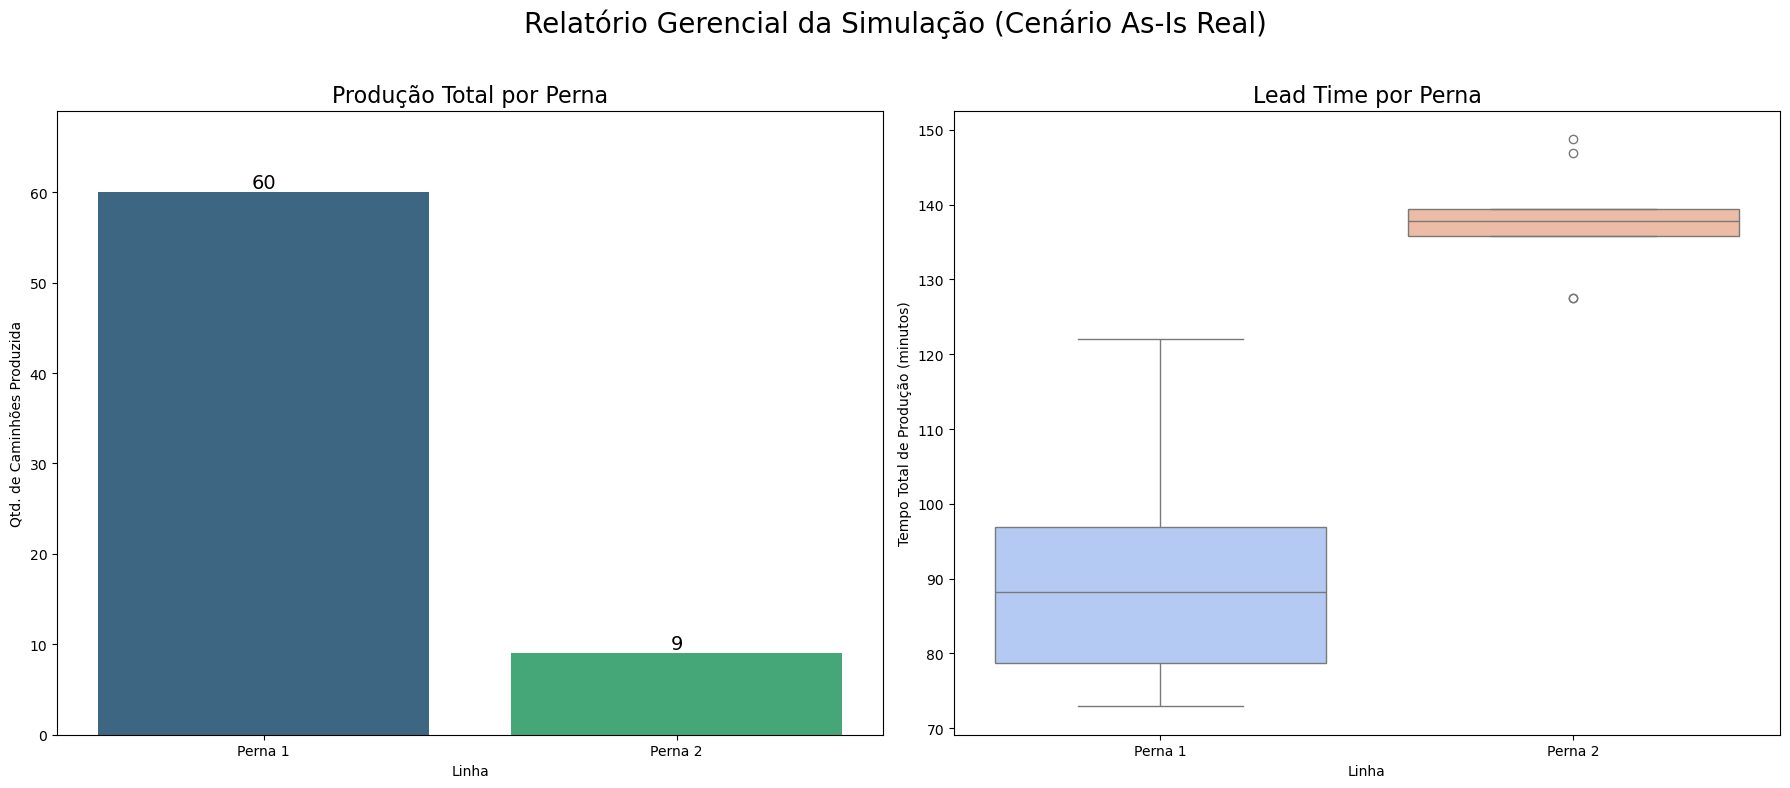

In [9]:
# ETAPA 3: EXECUÇÃO E RELATÓRIOS

if not PROCESSOS_FABRICA:
    print("\n[ERRO FATAL] Nenhum dado foi carregado.")
else:
    # --- ESTRUTURA ---
    env = simpy.Environment()
    resultados_simulacao = []
    
    fabrica = {
        "operadores": {
            "Perna 1": simpy.Resource(env, capacity=NUM_OPERADORES_PERNA1),
            "Perna 2": simpy.Resource(env, capacity=NUM_OPERADORES_PERNA2)
        }, "linhas": {"Perna 1": {}, "Perna 2": {}}
    }
    
    postos_p1 = set().union(*(p.keys() for m, p in PROCESSOS_FABRICA.items() if m in ["Accelo", "Atego", "ATP"]))
    fabrica['linhas']['Perna 1'] = {posto: simpy.Resource(env, capacity=1) for posto in postos_p1}
    postos_p2 = set().union(*(p.keys() for m, p in PROCESSOS_FABRICA.items() if m in ["Actros", "Arocs"]))
    fabrica['linhas']['Perna 2'] = {posto: simpy.Resource(env, capacity=1) for posto in postos_p2}
    
    # --- EXECUÇÃO ---
    print("\n--- Iniciando Simulação: Cenário 'As-Is' Real ---")
    print(f"Takt Time: {TAKT_TIME_SEGUNDOS/60:.2f} min | Perna 1: {NUM_OPERADORES_PERNA1} op. | Perna 2: {NUM_OPERADORES_PERNA2} op.")
    
    env.process(gerador_de_producao(env, fabrica, resultados_simulacao, TAKT_TIME_SEGUNDOS))
    env.run(until=HORAS_SIMULACAO * 3600)
    
    print("\n" + "="*60)
    print("      RELATÓRIO GERENCIAL DA SIMULAÇÃO (AS-IS)")
    print("="*60)

    # --- ANÁLISE DOS RESULTADOS ---
    df_resultados = pd.DataFrame(resultados_simulacao)
    
    if df_resultados.empty:
        print("\nNenhum caminhão completou a produção.")
    else:
        # 1. Análise da Meta de Produção
        df_meta_batida = df_resultados[df_resultados['Tempo_Saida_min'] <= HORAS_META * 60]
        qtd_na_meta = len(df_meta_batida)
        
        print("\n--- 1. ANÁLISE DA META DE PRODUÇÃO (c/ 'Fator Cagaço') ---")
        if qtd_na_meta >= META_PRODUCAO:
            print(f" SUCESSO! A meta foi batida, com {qtd_na_meta} caminhões produzidos nas primeiras {HORAS_META} horas.")
        else:
            print(f" FALHA! Apenas {qtd_na_meta} de {META_PRODUCAO} caminhões foram produzidos nas primeiras {HORAS_META} horas.")

        # 2. Análise de Desempenho
        print("\n--- 2. DESEMPENHO POR PERNA ---")
        desempenho = df_resultados.groupby('Linha').agg(
            Qtd_Produzida=('ID', 'count'),
            Lead_Time_Medio_min=('LeadTime_min', 'mean'),
            Tempo_Medio_Espera_min=('Tempo_Espera_min', 'mean')
        ).round(2)
        print(desempenho)

        # 3. Novo Relatório Visual
        print("\n--- 3. Gerando Relatório Visual Gerencial ---")
        fig, axes = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1]})
        fig.suptitle('Relatório Gerencial da Simulação (Cenário As-Is Real)', fontsize=20)

        # Gráfico 1: Produção por Perna
        prod_counts = df_resultados['Linha'].value_counts().reindex(['Perna 1', 'Perna 2']).fillna(0)
        sns.barplot(x=prod_counts.index, y=prod_counts.values, ax=axes[0], palette='viridis', hue=prod_counts.index, legend=False)
        axes[0].set_title('Produção Total por Perna', fontsize=16)
        axes[0].set_ylabel('Qtd. de Caminhões Produzida')
        axes[0].set_ylim(0, prod_counts.max() * 1.15)
        for i, v in enumerate(prod_counts.values):
            axes[0].text(i, v, str(int(v)), ha='center', va='bottom', fontsize=14)
        
        # Gráfico 2: Lead Time por Perna
        sns.boxplot(x='Linha', y='LeadTime_min', data=df_resultados, ax=axes[1], palette='coolwarm', hue='Linha', order=['Perna 1', 'Perna 2'], legend=False)
        axes[1].set_title('Lead Time por Perna', fontsize=16)
        axes[1].set_ylabel('Tempo Total de Produção (minutos)')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig('relatorio_gerencial_real.png')
        print(" SUCESSO: Gráfico 'relatorio_gerencial_real.png' salvo.")